#### Visualization Of Patterns Learned By Different ConvNets Architecture

In this section, we look into what sort of visual patterns image classification models learn.
Our process is simple: we will create an input images that maximize the activation of specific filters in a target layer.
Such image represent a visualization of patterns that the filters respond.

In [8]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from IPython.display import Image, display

# The dimensions of our input image
img_width = 224
img_height = 224

#### Building a feature extractor

In [9]:
model = keras.applications.VGG19(weights="imagenet", include_top=False)
#model = keras.applications.MobileNetV2(weights="imagenet", include_top=False)

In [10]:
model.summary()

Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [11]:
# Set up a model that returns the activation values for our target layer
layer_name = 'block3_conv4'
layer = model.get_layer(name=layer_name)
feature_extractor = keras.Model(inputs=model.inputs, outputs=layer.output)

In [12]:
feature_extractor.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0   

#### Set up the gradient ascent process

The "loss" we will maximize is simply the mean of the activation of a specific filter in our target layer. To avoid border effects, we exclude border pixels.

In [13]:
def compute_loss(input_image, filter_index):
    activation = feature_extractor(input_image)
    # We avoid border artifacts by only involving non-border pixels in the loss.
    filter_activation = activation[:, 2:-2, 2:-2, filter_index] # filter index choose the particular filter
    return tf.reduce_mean(filter_activation)


In [18]:
img = initialize_image()
print(compute_loss(img, 0))


tf.Tensor(12.436462, shape=(), dtype=float32)


Our gradient ascent function simply computes the gradients of the loss above with regard to the input image, and update the update image so as to move it towards a state that will activate the target filter more strongly.

In [15]:
@tf.function
def gradient_ascent_step(img, filter_index, learning_rate):
    with tf.GradientTape() as tape:
        tape.watch(img)
        loss = compute_loss(img, filter_index)
    # Compute gradients.
    grads = tape.gradient(loss, img)
    # Normalize gradients.
    grads = tf.math.l2_normalize(grads)
    img += learning_rate * grads # this is gradient ascent.
    return loss, img

#### Set up the end-to-end filter visualization loop
Our process is as follow:

1) Start from a random image that is close to "all gray" (i.e. visually netural)
2) Repeatedly apply the gradient ascent step function defined above
3) Convert the resulting input image back to a displayable form, by normalizing it, center-cropping it, and restricting it to the [0, 255] range.

In [16]:
def initialize_image():
    # We start from a gray image with some random noise
    img = tf.random.uniform((1, img_width, img_height, 3))
    # VGG19 expects inputs in the range [-1, +1].
    # Here we scale our random inputs to [-0.125, +0.125]
    return (img - 0.5) * 0.25
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
(1, 224, 224, 3)


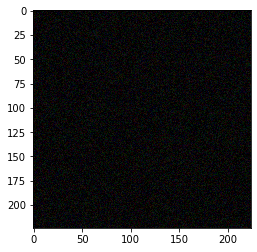

In [19]:
img = initialize_image()
print(img.shape)
plt.imshow(img[0])


In [20]:
def visualize_filter(filter_index):
    # We run gradient ascent for 20 steps
    iterations = 50
    learning_rate = 10.0
    img = initialize_image()
    for iteration in range(iterations):
        loss, img = gradient_ascent_step(img, filter_index, learning_rate)

    # Decode the resulting input image
    img = deprocess_image(img[0].numpy())
    return loss, img

In [21]:
def deprocess_image(img):
    # Normalize array: center on 0., ensure variance is 0.15
    img -= img.mean()
    img /= img.std() + 1e-5
    img *= 0.15

    # Center crop
    img = img[25:-25, 25:-25, :]

    # Clip to [0, 1]
    img += 0.5
    img = np.clip(img, 0, 1)

    # Convert to RGB array
    img *= 255
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [23]:
loss, img = visualize_filter(255)

In [24]:
keras.preprocessing.image.save_img("block3_conv4.png", img)

This is what an input that maximizes the response of filter 0 in the target layer would look like:

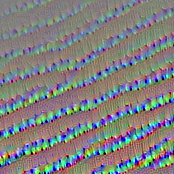

In [25]:
display(Image("block3_conv4.png"))

In [115]:
# Compute image inputs that maximize per-filter activations
# for the first 64 filters of our target layer
all_imgs = []
for filter_index in range(9):
    print("Processing filter %d" % (filter_index,))
    loss, img = visualize_filter(filter_index)
    all_imgs.append(img)

# Build a black picture with enough space for
# our 3 x 3 filters of size 128 x 128, with a 5px margin in between
margin = 5
n = 3
cropped_width = img_width - 25 * 2
cropped_height = img_height - 25 * 2
width = n * cropped_width + (n - 1) * margin
height = n * cropped_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, 3))

# Fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img = all_imgs[i * n + j]
        stitched_filters[
            (cropped_width + margin) * i : (cropped_width + margin) * i + cropped_width,
            (cropped_height + margin) * j : (cropped_height + margin) * j
            + cropped_height,
            :,
        ] = img
keras.preprocessing.image.save_img("block5_conv4.png", stitched_filters)

from IPython.display import Image, display


Processing filter 0
Processing filter 1
Processing filter 2
Processing filter 3
Processing filter 4
Processing filter 5
Processing filter 6
Processing filter 7
Processing filter 8
